In [9]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import prepState
from numpy import linalg as LA
from timeEvo import *
from generateStates import *
from qutip import *

# for using tex formatting and font in plots

plt.rcParams.update({"text.usetex": True,}) 
mpl.rcParams['text.latex.preamble'] = [r'\usepackage[utf8]{inputenc}\usepackage[T1]{fontenc}\usepackage{lmodern}\inputencoding{utf8}\usepackage{amsmath}\usepackage{amssymb}\usepackage{dsfont}\usepackage{mathtools}\usepackage{physics}']
mpl.rcParams['font.family'] = ['serif']

In [10]:
## a lot of functions
#
def generateStates(N):
    myStates = {}
    myBasis = {}
    for i in range(N+1):
        myStates["sigmaX", i] = prepState.stateX(N,i)
        myStates["sigmaY", i] = prepState.stateY(N,i)
        myStates["sigmaZ", i] = prepState.stateZ(N,i)
        myBasis["zero",i] = prepState.state0(N,i)
        myBasis["one",i] = prepState.state1(N,i)

    l = 1

    Hint = 0
    for i in range(N): # interaction hamiltonian, XY-Heisenberg
        Hint = Hint + l / 2 * np.sqrt((i+1)*(N-i)) * (myStates["sigmaX", i] * myStates["sigmaX", i+1] + myStates["sigmaY", i] * myStates["sigmaY", i+1])
    J = 1/2
    Hint = J * Hint # change interaction strength 

    H0 = 0
    for i in range(1,N+1):
            H0 = H0 - myStates["sigmaZ", i]

    return Hint


def generateRho(beta):
    rho = (-beta * sigmaz()).expm()
    Z = rho.tr()
    rho = rho/Z
    return rho


def timeEvo(dt, rho, Hint): # time evolution of an operator rho, SE approach as opposed to me approach
	U = (-1.j * Hint * dt).expm()
	Ud = (1.j * Hint * dt).expm()
	rho = rho * Ud
	return U * rho

In [ ]:
## define plot parameters
#
# this is not really for anything, just for me to copy paste
def plotOne(ylabel,howmany,what,title):
    fig, ax = plt.subplots()
    for i in howmany:
        ax.plot(t, what, label="F(t)")#, '+')
    ax.set_title(title)
    ax.set_xlabel("time")
    ax.set_ylabel(ylabel)
    ax.axvline(np.pi,color='grey')
    ax.axhline(1,color='grey')
    plt.show(block=True)

In [28]:
## define constants
#
N=4
beta = 1
alpha = 1.j * .25 * 1/(np.cosh(beta))**2
astar = -alpha
n = 3200
dt = 1e-3
t = np.linspace(0, n*dt, n)

In [29]:
## initiate States
#
rho = generateRho(beta)
firstState = rho
initSystem = tensor(firstState, rho) + alpha * tensor(Qobj([[0,1],[0,0]]), Qobj([[0,0],[1,0]])) + astar * tensor(Qobj([[0,0],[1,0]]), Qobj([[0,1],[0,0]]))

Hint = generateStates(N)

for n in range(1,N):
	initSystem = tensor(initSystem, Qobj([[1,0],[0,0]]))

qResult = qutip.mesolve(Hint, initSystem, t, [], []).states # mesolve = master equation approach
myResult = [timeEvo(dt, initSystem, Hint) for dt in t]

In [31]:
## a shitton of quantities, the lists are always the values as a function of t
#

myFidelity = [fidelity(firstState, myResult[i].ptrace(N).unit()) for i in range(0,n+1)]
qEnt = [entropy_vn(timeEvo(dt, initSystem, Hint).ptrace(N), base=np.e) for dt in t]
myInfoflow = np.diff(qEnt)/dt
myHeatlim = [-1.j *(np.pi/3 *1 / (np.log(2)**2)) * (commutator(timeEvo(dt, initSystem, Hint), Hint).unit().ptrace(N) * sigmaz()).tr() for dt in t]
myKLdiv = [entropy_relative(firstState.unit(), timeEvo(dt, initSystem, Hint).ptrace(N)) for dt in t]
myHeatflow = [-1.j * (commutator(timeEvo(dt, initSystem, Hint), Hint).unit().ptrace(N) * sigmaz()).tr() for dt in t]
myInfoflow2 = [myInfoflow[n]**2 for n in range(len(myInfoflow))]

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1365: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


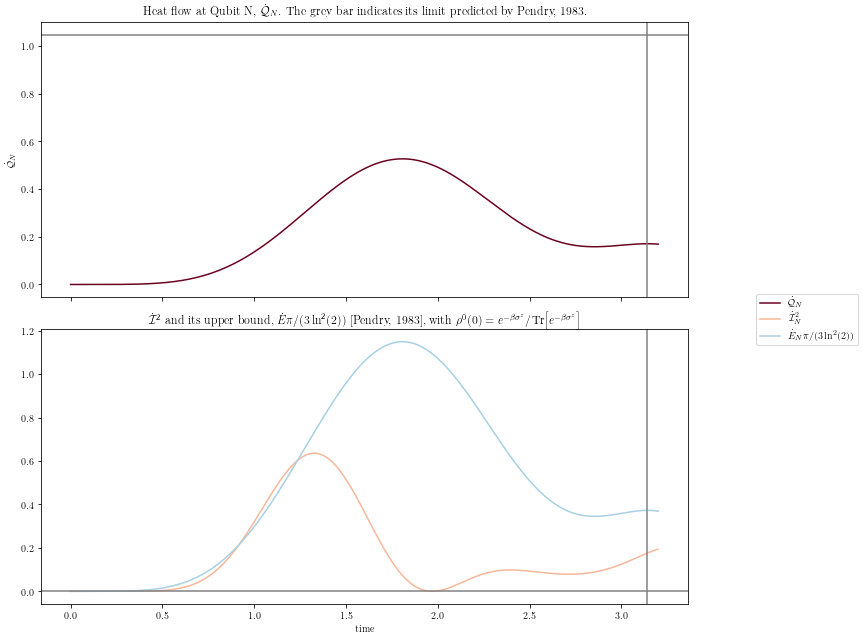

In [33]:
## plots
#

fig, (ax2, ax3) = plt.subplots(2,1,sharex=True, figsize=(12,9))
cmap = mpl.cm.get_cmap('RdBu')

ax3.plot(t[:-1], myInfoflow2, color=cmap(1/3), label="$\dot{\mathcal{I}}_N^2$")
ax3.plot(t, myHeatlim, color = cmap(2/3), label="$\dot{E}_N\pi/(3\ln^2(2))$")
ax2.plot(t, myHeatflow, color = cmap(1), label="$\dot{\mathcal{Q}}_N$")
ax3.set_xlabel("time")
ax2.set_ylabel("$\dot{\mathcal{Q}}_N$")
ax2.set_title(r"Heat flow at Qubit N, $\dot{\mathcal{Q}}_N$. The grey bar indicates its limit predicted by Pendry, 1983.")
ax3.set_title("$\dot{\mathcal{I}}^2$ and its upper bound, $\dot{E}\pi/(3\ln^2(2))$ [Pendry, 1983], with $\\rho^0(0) = e^{-\\beta\sigma^z}/\Tr[e^{-\\beta\sigma^z}]$")
ax2.axhline(np.pi/3 /(beta**2),color='grey')
ax3.axhline(0,color='grey')
ax2.axvline(np.pi,color='grey')
ax3.axvline(np.pi,color='grey')
fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.8)